# Machine Learning Project 2020-2021

# Setup Environment
Before running this notebook, the user needs to configure a separate conda environment in order to reproduce the results obtained. An environment.yml file is provided in the project repository with this objective. By creating a conda environment through the yml file, the user will be able to run the whole project without issues. Besides, the user also need to install an additional package from a personal github repository since it is not available in pypi nor in conda repositories.

In order to create the environment the user needs to run the following commands in the anaconda prompt: **conda env create -f \<path to environment.yml>**. Afterwards, the user needs to activate the created environment: **conda activate ml** and initialize the jupyter notebook: **jupyter notebook**.

In [1]:
import sys
#!{sys.executable} -m pip install git+https://github.com/johnruiz24/ML_Project 

## 1 - Importing Packages

In [154]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
#EDA Libraries
import dtale
import sweetviz as sv
import pandas_profiling
from pandas_profiling import ProfileReport
#ML Libraries
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

import sklearn.preprocessing as prep
import sklearn.covariance as cov #Elliptic Envelop
from scipy.stats import chi2

%matplotlib inline
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# 2 - Data Import and integration

In [2]:
train =pd.read_excel(os.path.join(os.getcwd(),'Train.xlsx'))

In [4]:
#train

In [3]:
test=pd.read_excel(os.path.join(os.getcwd(),'Test.xlsx'))

# 3 - Exploring Data

In [6]:
#Dimension of the training dataset
train.shape

(22400, 15)

In [7]:
#Dimension of the testing data
test.shape

(10100, 14)

In [8]:
#Data types for the train dataset 
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [9]:
#Data types for the testing dataset 
test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              10100 non-null  int64 
 1   Name                    10100 non-null  object
 2   Birthday                10100 non-null  object
 3   Native Continent        10100 non-null  object
 4   Marital Status          10100 non-null  object
 5   Lives with              10100 non-null  object
 6   Base Area               10100 non-null  object
 7   Education Level         10100 non-null  object
 8   Years of Education      10100 non-null  int64 
 9   Employment Sector       10100 non-null  object
 10  Role                    10100 non-null  object
 11  Working Hours per week  10100 non-null  int64 
 12  Money Received          10100 non-null  int64 
 13  Ticket Price            10100 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 1.1+ MB


In [10]:
#Check duplicates
any(train.duplicated())

False

In [11]:
#Check duplicates
any(test.duplicated())

False

In [4]:
# after a first inspection of the train data excel file, we found out that some columns are the following string: '?' so bellow we check the quantity of '?' string and what columns have them. 
def checkdf_character(df,char): 
    for i in range(len(df.columns)):
        #Printing the column names, number of rows & percentage of rows from the dataset
        #Further details will be printed in the next lines through the utilization of EDA tools
        size=len(df.loc[df.iloc[:,i].astype(str).str.startswith('?')])
        if size>0:
            print('------------------------------------------')
            print('Column: {}{}Number of Rows: {}{}Percentage: {}%'.format(df.columns[i],'\n',size,'\n',round(size/len(df)*100,2)))

In [13]:
#Data inspection shows that the train dataset has rows with question mark '?' character
checkdf_character(train,'?')

------------------------------------------
Column: Base Area
Number of Rows: 395
Percentage: 1.76%
------------------------------------------
Column: Employment Sector
Number of Rows: 1264
Percentage: 5.64%
------------------------------------------
Column: Role
Number of Rows: 1271
Percentage: 5.67%


In [14]:
#Data inspection shows that the test dataset has rows with question mark '?' character
checkdf_character(test,'?')

------------------------------------------
Column: Base Area
Number of Rows: 187
Percentage: 1.85%
------------------------------------------
Column: Employment Sector
Number of Rows: 570
Percentage: 5.64%
------------------------------------------
Column: Role
Number of Rows: 570
Percentage: 5.64%


In [15]:
#Frequencies of number of missing values across rows
train.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    22400
dtype: int64

In [16]:
#Frequencies of number of missing values across rows
test.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index()

0    10100
dtype: int64

- Identify the outliers before going to the data preparation ? 

In [17]:
#dtale.show(train)

# 4 - Modify the Data / Data Preparation 

# 4.1 Creating two new features from existing variables.

### 4.1.1 - Creating Gender from the variable Name, 0 for male and 1 for female.

In [5]:
train_upd = train.copy()

In [19]:
checkdf_character(train_upd,'?')

------------------------------------------
Column: Base Area
Number of Rows: 395
Percentage: 1.76%
------------------------------------------
Column: Employment Sector
Number of Rows: 1264
Percentage: 5.64%
------------------------------------------
Column: Role
Number of Rows: 1271
Percentage: 5.67%


In [6]:
train_upd.insert(2,'Gender',train_upd['Name'].str.slice(0,4).str.replace('.','').str.replace(' ',''))

In [7]:
train_upd['Gender']=train_upd['Gender'].apply(lambda i: 0 if i=='Mr' else 1)

In [8]:
train_upd['Gender'].unique()

array([0, 1], dtype=int64)

### 4.1.2 - Creating Age from the variable Birthday

In [9]:
train_upd.insert(4,'Age',pd.Series([]))
for i,j in enumerate(list(train_upd['Birthday'].values)):
    try:
        train_upd['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ',''),'%B%d,%Y'))/timedelta(days=365.2425))
    except ValueError:
        train_upd['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ','').replace('9','8'),'%B%d,%Y'))/timedelta(days=365.2425))

In [10]:
train_upd['Age']=train_upd['Age'].astype('uint8')

In [11]:
train_upd

,CITIZEN_ID,Name,Gender,Birthday,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,0,"July 1,2003",45,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,0,"January 25,2006",43,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,0,"May 10,2009",40,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,0,"March 25,1985",64,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,0,"May 29,2015",34,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,Mrs. Lisa Alsop,1,"March 15,2023",26,Europe,Divorced,Children,Northbury,Professional School,12,Private Sector - Services,Cleaners & Handlers,40,0,0,0
22396,34882,Mr. Julian Coleman,0,"March 7,2025",24,Europe,Single,Children,Northbury,Professional School,12,Private Sector - Services,Other services,35,0,0,0
22397,34883,Miss Amelia Walker,1,"July 20,2022",26,Europe,Single,Other Family,Northbury,Masters,17,Public Sector - Others,Professor,40,2674,0,0
22398,34884,Mr. Justin Sutherland,0,"June 11,2011",37,Europe,Single,Other Family,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Repair & constructions,90,0,0,1


# 4.2 - Filling the values with '?'

In [12]:
# since we are using IterativeImputer() to fill the '?' string values we need to change them to NaN's so the algorigthm works.
for i in [8,11,12]:
    aIndex=np.array(train_upd[train_upd.iloc[:,i].astype(str).str.startswith('?')].iloc[:,i].index)
    for j in aIndex:
        train_upd.iloc[j,i]=np.nan

train_upd.isna().sum()

CITIZEN_ID                   0
Name                         0
Gender                       0
Birthday                     0
Age                          0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [13]:
#Creating a data frame with the categorical variables.
#cat_col = train_upd.select_dtypes(include=['object']).columns.values # Because it does encode numeric features like years of education. 
cat_col = train_upd[['Name','Birthday','Native Continent','Marital Status','Lives with','Base Area','Education Level','Employment Sector','Role']].columns.values
cat_col

array(['Name', 'Birthday', 'Native Continent', 'Marital Status',
       'Lives with', 'Base Area', 'Education Level', 'Employment Sector',
       'Role'], dtype=object)

In [14]:
encoder = OrdinalEncoder()

In [15]:
mice = IterativeImputer()

In [16]:
def encode(data):
    reshape = np.array(data.dropna()).reshape(-1,1)
    ordinal = encoder.fit_transform(reshape)
    data.loc[data.notnull()] = np.squeeze(ordinal)
    return data

In [17]:
# Not running for now.
for col in cat_col: 
    encode(train_upd[col])

In [18]:
#Filling NaN according to Mice algorigthm. 
train_upd=pd.DataFrame(np.round(mice.fit_transform(train_upd)),columns=train_upd.columns)

In [19]:
# double check to what was done.
train_upd.isna().sum()

CITIZEN_ID                0
Name                      0
Gender                    0
Birthday                  0
Age                       0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
dtype: int64

In [39]:
#train_upd

# 4.3 Removing the Outliers - Using mahalanobis

In [40]:
#John needs to check. 
main_data = train_upd.copy().reset_index()
main_data['id'] = main_data.index

In [41]:
metric_data = main_data.loc[:,(np.array(main_data.dtypes=="float64")) | (np.array(main_data.dtypes=="int64"))]

data = metric_data.set_index("id")

yj = prep.PowerTransformer(method='yeo-johnson')
qt = prep.QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=np.random.RandomState(104))

X_trans_yj = yj.fit_transform(data)
X_trans_qt = qt.fit_transform(data)

# Merging
X_trans = np.concatenate((X_trans_yj, X_trans_qt), axis=1)

# Creating DataFrame
merge_labels = list(map(lambda x: "yj_" + x, data.columns.to_list()))+list(map(lambda x: "qt_" + x, data.columns.to_list()))
trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=data.index)

In [42]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [43]:
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # Obtain mahalanobis distance of each observation to the center and then sort it
    ee_out = cov.EllipticEnvelope(contamination=0.2, support_fraction=0.95, random_state=np.random.RandomState(304)).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # Obtain chi-square percentiles of each observations
    quantiles = chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # Obtain labels
    labels = ee_out.predict(data)    
    return mahalan, quantiles, labels

In [44]:
mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)

In [45]:
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)

In [46]:
lqt_lyj = pd.DataFrame({'lqt': lqt, 'lyj': lyj})

In [47]:
# checking outliers precentage
inl = lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1)].sum()['lqt']
'Outliers percentage: {:4.2f}%'.format(100 - inl/len(lqt_lyj) * 100)

'Outliers percentage: 27.08%'

In [48]:
# creating mask for outliers' drop
lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1), 'mask'] = True
lqt_lyj.fillna(False, inplace=True)
lqt_lyj.drop(columns=['lqt', 'lyj'], inplace=True)

# 4.4 - Divinding the data in 3 different data sets - because we have 3 distinct groups, Volunteers, Essencial and ticket buyers. 

In [20]:
train_upd = train_upd.astype(int)

In [47]:
train_upd_a=train_upd[(train_upd['Ticket Price']==0) & (train_upd['Money Received']==0)].copy() #Volunteers
train_upd_b=train_upd[train_upd['Money Received']>0].copy()#received money
train_upd_c=train_upd[train_upd['Ticket Price']>0].copy()#buying entry

In [ ]:
# DO NOT RUN, It's here fow now, just for reference.
#group a
#df1=train_upd_a.copy()
#for c in cat_col:
    #encode(df1[c])

In [ ]:
## DO NOT RUN, It's here fow now, just for reference.
#group b
#df2=train_upd_b.copy()
#for c in cat_col:
    #encode(df2[c])

In [ ]:
# DO NOT RUN, It's here fow now, just for reference.
#group c
#df3=train_upd_c.copy()
#for c in cat_col:
    #encode(df3[c])

# We could also try lasso regression, it's more accurate and easier to understand. 

# 4.5 - RFE - Recursive Feature Selection

In [48]:
def rfe_group(df):
    data = df.iloc[:,:-1]
    target = df.iloc[:,-1]
    nof_list=np.arange(1,len(data.columns)+1)  
    high_score=0
    nof=0           
    score_list =[]
    #dividing the data sets into train and validation. 
    for n in range(len(nof_list)):
        X_train, X_test, y_train, y_test = train_test_split(data,target, test_size = 0.2, random_state = 0,stratify = target)
        
        #Selecting the model for the Feature selection.
        model = LogisticRegression()
        rfe = RFE(model,nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)

        score = model.score(X_test_rfe,y_test)
        score_list.append(score)

        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print("Optimum number of features: %d" %nof)
    print('\n')
    print("Score with %d features: %f" % (nof, high_score))
    rfe = RFE(estimator = model, n_features_to_select = nof)
    X_rfe = rfe.fit_transform(X = data, y = target)
    model = LogisticRegression().fit(X = X_rfe,y = target)
    selected_features = pd.Series(rfe.support_, index = data.columns)
    print(selected_features)
    ridge = RidgeClassifierCV().fit(X = data,y = target)
    coef_ridge = pd.Series(ridge.coef_[0], index = data.columns)
    return coef_ridge

In [49]:
#Ploting the features importance with ridge regression. 
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name)
    plt.show()

Optimum number of features: 8


Score with 8 features: 0.841148
CITIZEN_ID                False
Name                      False
Gender                     True
Birthday                  False
Age                        True
Native Continent           True
Marital Status             True
Lives with                 True
Base Area                  True
Education Level           False
Years of Education         True
Employment Sector          True
Role                      False
Working Hours per week    False
Money Received            False
Ticket Price              False
dtype: bool


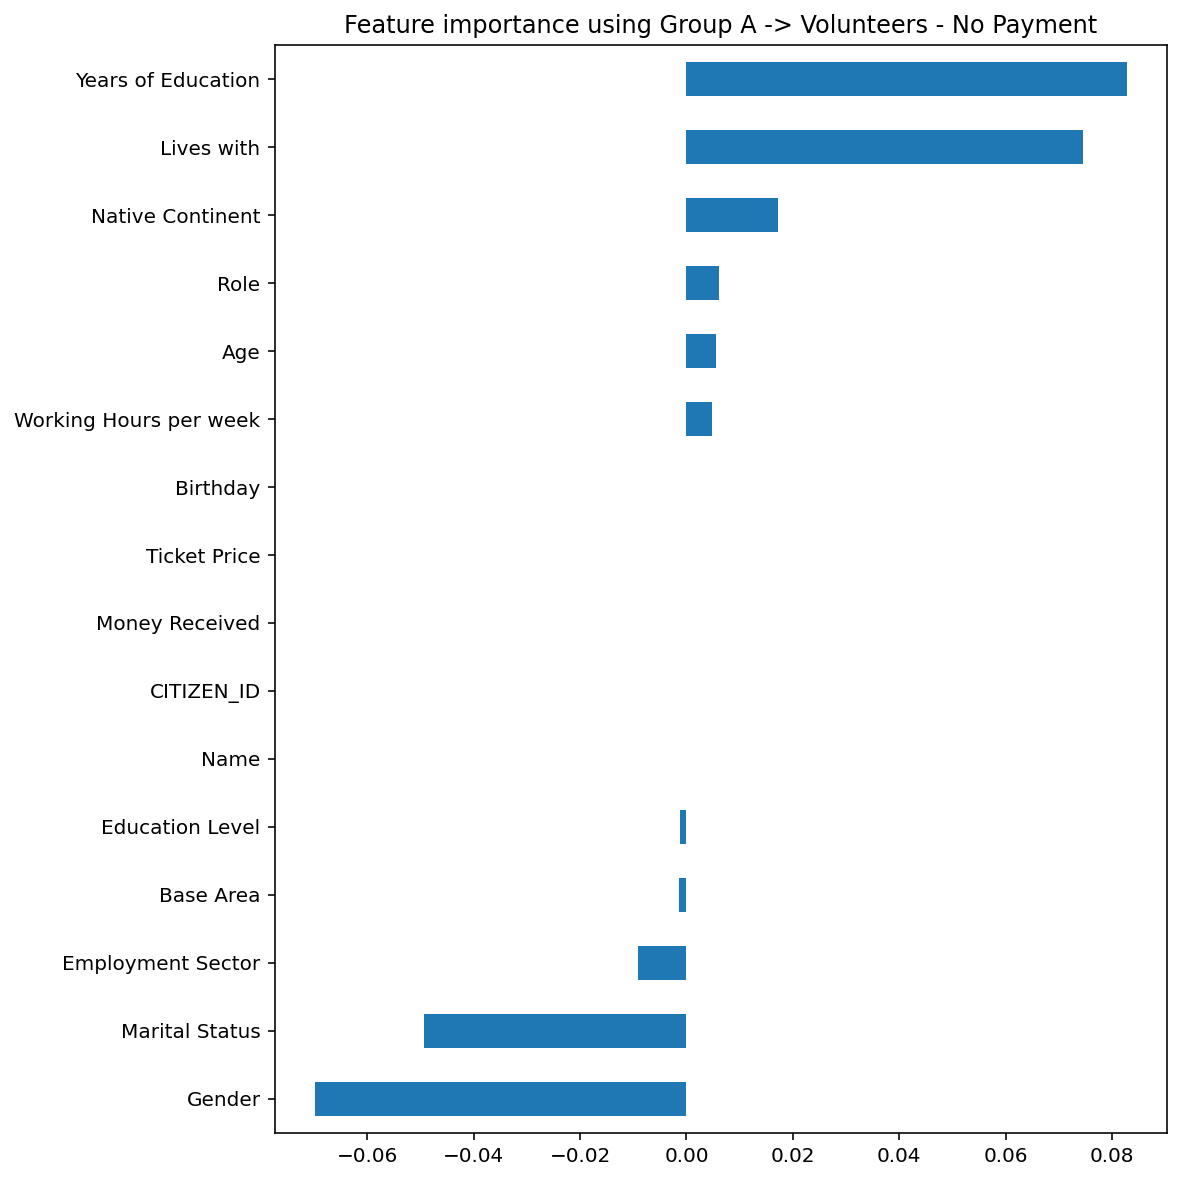

In [50]:
coef_ridge_1 = rfe_group(train_upd_a)
plot_importance(coef_ridge_1,'Group A -> Volunteers - No Payment')

In [51]:
# Selecting the Features for the Volunteers dataset.
train_upd_a.drop(['Birthday','Ticket Price','Money Received','Name','Education Level','Base Area'],axis=1,inplace=True)

In [52]:
train_upd_a.set_index('CITIZEN_ID',inplace=True) # Check later and after making changes if ID is still correct. 

In [53]:
# Checking score after removing the serveral variables. 
rfe_group(train_upd_a)

Optimum number of features: 7


Score with 7 features: 0.840892
Gender                     True
Age                       False
Native Continent           True
Marital Status             True
Lives with                 True
Years of Education         True
Employment Sector          True
Role                       True
Working Hours per week    False
dtype: bool


Gender                   -0.069871
Age                       0.005477
Native Continent          0.017444
Marital Status           -0.048399
Lives with                0.075357
Years of Education        0.083708
Employment Sector        -0.009273
Role                      0.006042
Working Hours per week    0.004741
dtype: float64

Optimum number of features: 13


Score with 13 features: 0.871935
CITIZEN_ID                False
Name                      False
Gender                     True
Birthday                   True
Age                        True
Native Continent           True
Marital Status             True
Lives with                 True
Base Area                  True
Education Level            True
Years of Education         True
Employment Sector          True
Role                       True
Working Hours per week     True
Money Received             True
Ticket Price              False
dtype: bool


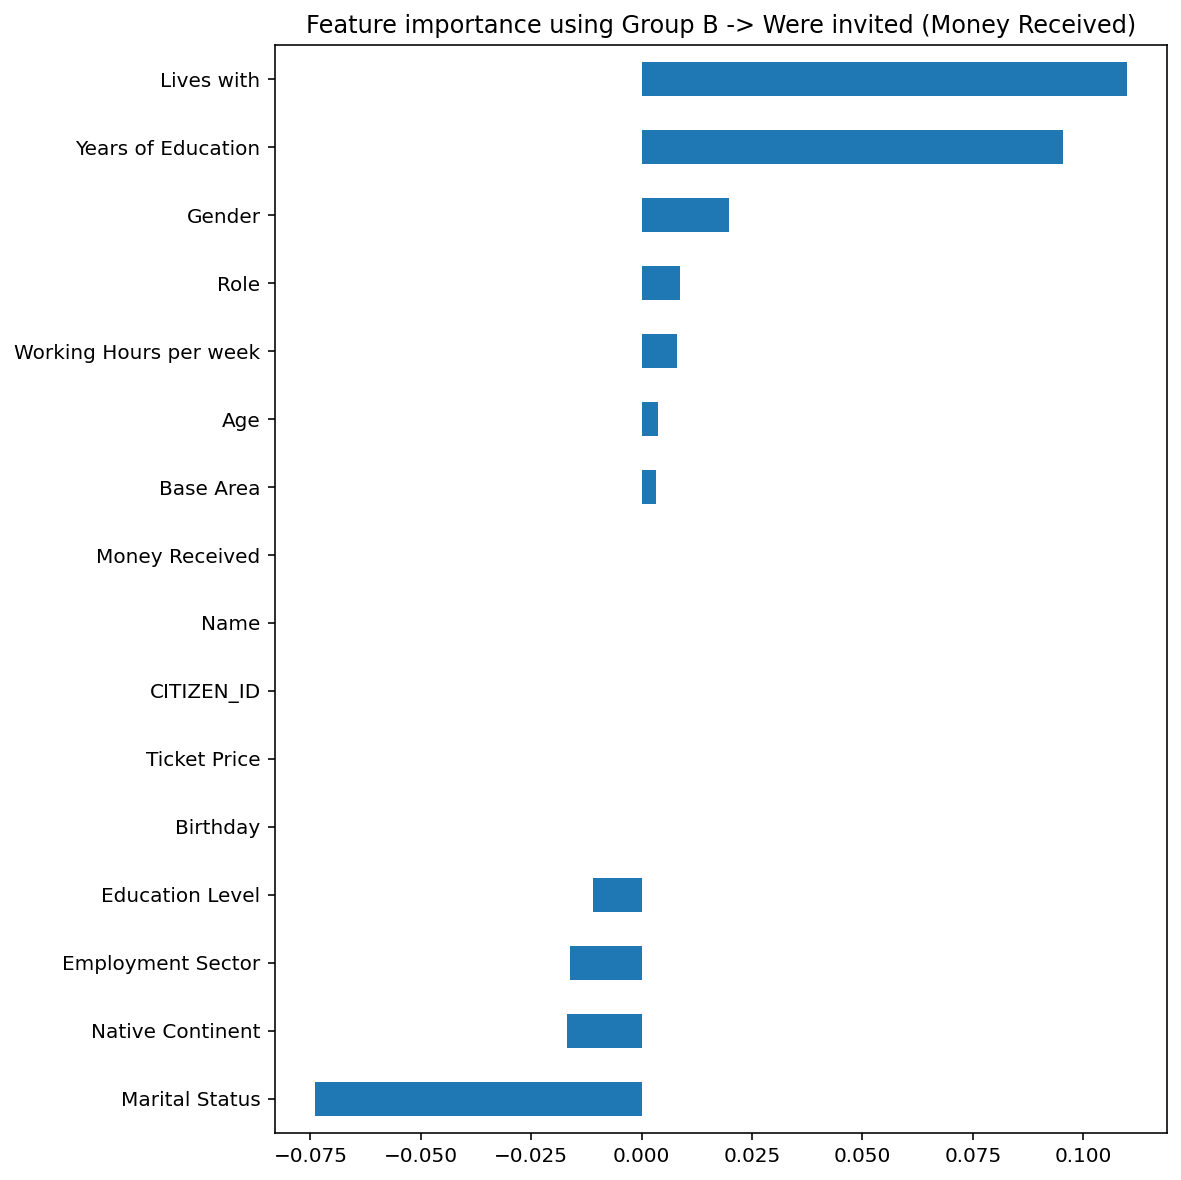

In [28]:
coef_ridge_2 = rfe_group(train_upd_b)
plot_importance(coef_ridge_2,'Group B -> Were invited (Money Received)')

In [54]:
# Selecting the Features for the essencials dataset.
train_upd_b.drop(['Birthday','Ticket Price','Money Received','Name','Base Area','Age'],axis=1,inplace=True) # We are letting Education lvl stay since it's has some weight. 

In [55]:
train_upd_b.set_index('CITIZEN_ID',inplace=True) # Check later and after making changes if ID is still correct. 

In [56]:
# Checking score after removing the serveral variables. 
rfe_group(train_upd_b)

Optimum number of features: 2


Score with 2 features: 0.735695
Gender                    False
Native Continent          False
Marital Status            False
Lives with                 True
Education Level           False
Years of Education         True
Employment Sector         False
Role                      False
Working Hours per week    False
dtype: bool


Gender                    0.037615
Native Continent         -0.019923
Marital Status           -0.087348
Lives with                0.117337
Education Level          -0.007872
Years of Education        0.116507
Employment Sector         0.006597
Role                      0.008874
Working Hours per week    0.008842
dtype: float64

Optimum number of features: 3


Score with 3 features: 0.764151
CITIZEN_ID                False
Name                      False
Gender                    False
Birthday                  False
Age                       False
Native Continent          False
Marital Status             True
Lives with                 True
Base Area                 False
Education Level           False
Years of Education         True
Employment Sector         False
Role                      False
Working Hours per week    False
Money Received            False
Ticket Price              False
dtype: bool


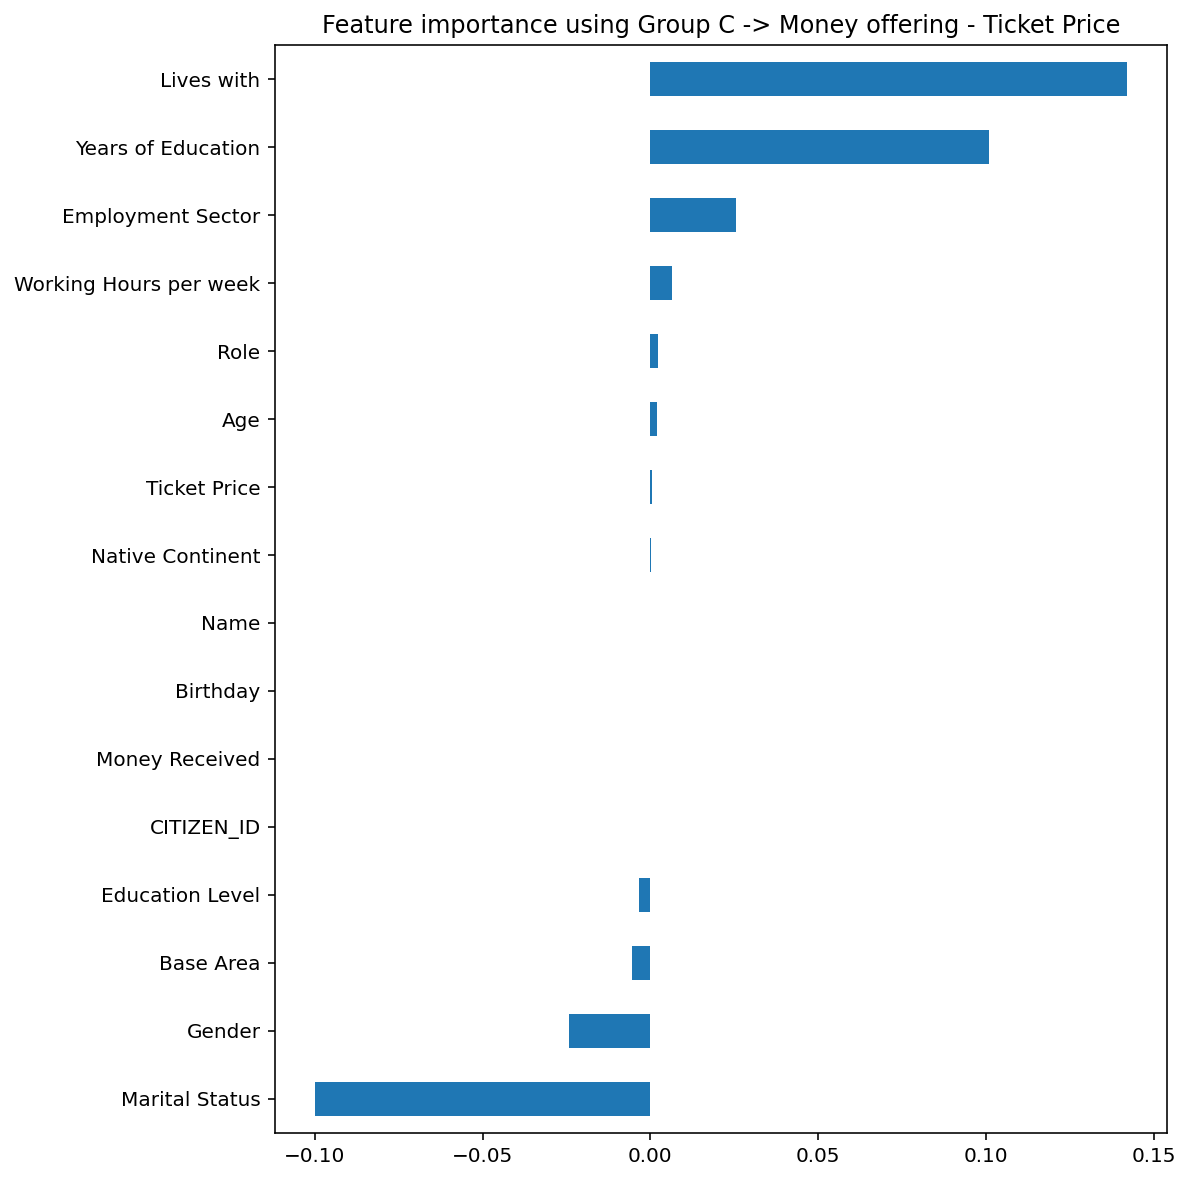

In [32]:
coef_ridge_3 = rfe_group(train_upd_c)
plot_importance(coef_ridge_3,'Group C -> Money offering - Ticket Price')

In [57]:
# Selecting the Features for the essencials dataset.
train_upd_c.drop(['Birthday','Ticket Price','Money Received','Name','Base Area','Age','Role','Education Level'],axis=1,inplace=True) # We are letting Education lvl stay since it's has some weight. 

In [58]:
train_upd_c.set_index('CITIZEN_ID',inplace=True) # Check later and after making changes if ID is still correct. 

In [59]:
# Checking score after removing the serveral variables. 
rfe_group(train_upd_c)

Optimum number of features: 3


Score with 3 features: 0.764151
Gender                    False
Native Continent          False
Marital Status             True
Lives with                 True
Years of Education         True
Employment Sector         False
Working Hours per week    False
dtype: bool


Gender                   -0.007362
Native Continent          0.001455
Marital Status           -0.100274
Lives with                0.166116
Years of Education        0.108189
Employment Sector         0.043221
Working Hours per week    0.007302
dtype: float64

# 5 - Modelling - Create a predictive model

In [74]:
#Spliting train and validation data
 # Volunteers dataset
data = train_upd_a.iloc[:,:-1]
target = train_upd_a.iloc[:,-1]

 #Essencials dataset
train_b = train_upd_b.iloc[:,:-1]
target_b = train_upd_b.iloc[:,-1]

#Ticket buyers
train_c = train_upd_c.iloc[:,:-1]
target_c = train_upd_c.iloc[:,-1]

In [137]:
X_train, X_val, y_train, y_val = train_test_split(data,target, test_size=0.2, random_state=3, stratify=target) #we are trying with different number of variables and the best score 
# was 3. 

In [138]:
log_model = LogisticRegression()

In [139]:
log_model.fit(X_train,y_train)

LogisticRegression()

In [145]:
y_pred = log_model.predict(X_val)
#y_pred

In [146]:
pred_prob = log_model.predict_proba(X_val)
#pred_prob

In [147]:
log_model.coef_

array([[-1.36282442,  0.02389141,  0.00151428, -0.21864864,  0.35705065,
         0.36235143,  0.07039497, -0.04878604,  0.02044046]])

In [148]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[2991,  182],
       [ 487,  243]], dtype=int64)

The confusion matrix in sklearn is presented in the following format: <br>
[ [ TN  FP  ] <br>
    [ FN  TP ] ]

In [149]:
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.8285933897002306

In [150]:
precision = precision_score(y_val, y_pred)
precision

0.571764705882353

In [151]:
recall_score(y_val, y_pred)

0.33287671232876714

In [152]:
f1 = f1_score(y_val, y_pred)
f1

0.4207792207792208

In [156]:
print('Results on the validation set:')
print(
    # write your code in here
    classification_report(y_true = y_val, y_pred = y_pred)
)

Results on the validation set:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3173
           1       0.57      0.33      0.42       730

    accuracy                           0.83      3903
   macro avg       0.72      0.64      0.66      3903
weighted avg       0.81      0.83      0.81      3903



# 4.1 Training Data

# 4.2 Validation Data

# 4.3 Testing Data

# 5) Applying ML techniques

# 6) Training

# 7) Evaluation / Assessment

# 8) Testing across the ML algos tested above

# 9) Adding to the analysis other ML algos

# 10) Optimization

# 11) Conclussion